In [38]:
# Import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
import yfinance as yf
from datetime import timedelta
import statsmodels.api as sm
import matplotlib.dates as mdates

In [39]:
# INDIVIDUAL SYMBOLS: Fama French 5-Factor Model ---- MONTHLY -----------

factors_data = pd.read_csv("factors_data.csv")

# List of symbols to filter out
lst = ["^GSPC"]

ff = pd.read_csv("ff.csv")

# Create a boolean mask where True indicates rows to keep
mask = ~ff['symbol'].isin(lst)
#print(ff)
# Apply the mask to the DataFrame to keep only the rows that do not match the list
ff = ff[mask]

ff['date'] = pd.to_datetime(ff['date'])
ff['month'] = ff["date"].dt.to_period('M')

ff.index = ff["date"] 
#print(ff)
ff['year'] = ff["date"]
ff["year"] = pd.to_datetime(ff['year'])
ff["year"] = ff["year"].dt.year



#--------------------------------------------------------------------------------

# DIVIDEND

# Create df containing monthly dividends for all stocks
ff['dividend'].fillna(0, inplace = True)
dividend = ff.groupby(["symbol", "month"]).agg(dividend = ("dividend", "sum")).reset_index()
dividend = dividend.rename(columns = {"month":"year_month"})
#print(dividend)                          

#--------------------------------------------------------------------------------



# CALCULATE MONTHLY PERCENTUAL PERFORMANCE / METRICS AS INPUT TO FF

# Group the dataframe by month and select the first and last rows for each month
res = ff.groupby(ff["month"]).apply(lambda x: x.iloc[[0, -1]])

# Drop the multi-level index, if present
if isinstance(res.index, pd.MultiIndex):
    res.index = res.index.droplevel(0)

# Reset the index without re-inserting 'date'
res = res.reset_index(drop = True)

# Initialize lists to store start and end dates
start_dates = []
end_dates = []

# Iterate over the dataframe to populate start and end dates
for i in res.index:
    if i % 2 == 0:
        start_dates.append(str(res["date"][i]))  # Append start date
    else:
        end_dates.append(str(res["date"][i]))  # Append end date

# Convert start_dates to a set and sort it
start_dates = sorted(set(start_dates))
s_start = pd.DataFrame(start_dates, columns = ["date"])
s_start['date'] = pd.to_datetime(s_start['date'])
s_start['month'] = s_start['date'].dt.to_period('M')

# Convert end_dates to a set and sort it
end_dates = sorted(set(end_dates))
s_end = pd.DataFrame(end_dates, columns=["date"])
s_end['date'] = pd.to_datetime(s_end['date'])
s_end['month'] = s_end['date'].dt.to_period('M')

# Merge the start dates with the original dataframe

ff = ff.reset_index(drop = True)

ff_start = pd.merge(ff, s_start, on = "date", how = "inner")
ff_start = ff_start.rename(columns = {
    "close_adjusted": "close_adjusted_start", "symbol": "symbol_start"})
#ff_start = ff_start.drop(columns=["year", "dividend", "close"])
ff_start = ff_start.drop(columns = ["year", "dividend"])

# Merge the end dates with the original dataframe
ff_end = pd.merge(ff, s_end, on = "date", how = "inner")
ff_end = ff_end.rename(
    columns = {"close_adjusted": "close_adjusted_end", "symbol": "symbol_end","month_x":"year_month"})
#ff_end = ff_end.drop(columns=["year", "dividend", "close"])
ff_end = ff_end.drop(columns = ["year", "dividend","month_y"])

# Concatenate start and end dataframes
ff_final = pd.concat([ff_start, ff_end], axis = 1)

# Calculate stock returns
ff_final["stock_returns"] = (ff_final["close_adjusted_end"] - ff_final["close_adjusted_start"])

# Grouping and aggregating the ff_final DataFrame
ff_final = ff_final.groupby(["symbol_start", "year_month"]).agg(
    stock_returns = ("stock_returns", "mean"),
    close_adjusted_start = ("close_adjusted_start", "sum")).reset_index()

#print(ff_final)
#print(factors_data)

# Convert 'year_month' column from PeriodDtype to datetime
ff_final['year_month'] = ff_final['year_month'].dt.to_timestamp()

# Now you can use the datetime methods
ff_final['year_month'] = ff_final['year_month'].dt.to_period('M')

factors_data['year_month'] = pd.to_datetime(factors_data['year_month'])
factors_data['year_month'] = factors_data['year_month'].dt.to_period('M')

# Merge the final dataframe with factors_data on the 'month' column using an outer join
ff_final = pd.merge(ff_final, factors_data, how = "outer", on = "year_month")
#print(ff_final)

ff_final["key"] = ff_final["symbol_start"] + ff_final["year_month"].astype(str)
#ff_final["key"] = ff_final["symbol_start"] + ff_final["year_month"].astype(str)
dividend["key"] = dividend["symbol"] + dividend["year_month"].astype(str)

columns = ["dividend", "key","year_month"]
dividend = dividend[columns]

# Merge the final dataframe with the dividend dataframe along the columns
ff_final = pd.merge(ff_final, dividend, how = "left", on = "key")

# Remove duplicated columns from the dataframe
ff_final = ff_final.loc[:, ~ff_final.columns.duplicated()]

# Fill NA values in 'close_adjusted_start' with 1
ff_final["close_adjusted_start"] = ff_final["close_adjusted_start"].fillna(1)

# Fill NA values in 'stock_returns' and 'dividend' with 0 before calculating excess returns
ff_final["stock_returns"] = ff_final["stock_returns"].fillna(0)
ff_final["dividend"] = ff_final["dividend"].fillna(0)

# Convert "RF" to percentage
ff_final["RF"] = ff_final["RF"] * 10

#
ff_final = ff_final.rename(columns = {"year_month_x": "year_month"})

ff_final["stock_returns"] = ff_final["stock_returns"] + ff_final["dividend"]

# Replace 0 with np.nan in the "stock_returns" column
ff_final["stock_returns"] = ff_final["stock_returns"].replace(to_replace = 0, value = np.nan)

# Create the adjusted_profit column
#trades_df_monthly['adjusted_profit'] = trades_df_monthly.apply(
 #   lambda row: row['profit'] if row['profit'] != row['prev_profit'] else 0, axis=1)


################################################################################################

#
dollar_gains = pd.read_csv("dollar_gains.csv")

columns_to_drop = ["SP 500 - B&H (IVV)", "DA ALL - B&H (SDY)"]

# Check if the columns to drop exist in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in dollar_gains.columns]

# Drop the existing columns
dollar_gains = dollar_gains.drop(existing_columns_to_drop, axis = 1)

# Update the DataFrame's columns
dollar_gains.columns = dollar_gains.columns
print(dollar_gains)
#
dollar_gains = dollar_gains.replace(0,np.nan)

# Function to normalize and calculate periodic returns
def normalize_and_calculate_periodic_returns(df, value_column):
    df_clean = df.dropna(subset=[value_column])
    df_clean[f'{value_column}_return_normalized'] = (df_clean[value_column] * 100) / df_clean[value_column].iloc[0]
    df_clean[f'{value_column}_periodic_returns'] = np.diff(df_clean[f'{value_column}_return_normalized'], prepend=np.nan) / df_clean[f'{value_column}_return_normalized'].shift(1)
    return df.merge(df_clean[['year_month', f'{value_column}_periodic_returns']], on = 'year_month', how='left')

# Normalize and calculate periodic returns for each stock in the dollar_gains dataframe
for column in dollar_gains.columns[1:]:  # Exclude 'year_month'
    dollar_gains = normalize_and_calculate_periodic_returns(dollar_gains, column)

# Rename the periodic returns columns by adding "_new" suffix
dollar_gains.columns = [col if not col.endswith('_periodic_returns_new') else col.replace(
    '_periodic_returns_new', '_new') for col in dollar_gains.columns]

# Drop the normalized columns if they are not needed
dollar_gains = dollar_gains.drop(columns = [
    col for col in dollar_gains.columns if 'return_normalized' in col])
#print(dollar_gains)

# Filter columns with "dollar" in their name and store them in 'dollar_gains'
all_perf = dollar_gains
#print(all_perf)

# Select the year_month column
year_month_column = all_perf[['year_month']]

# Filter columns that match the regex pattern _periodic_returns
all_perf = all_perf.filter(regex = '_periodic_returns')

# Concatenate the year_month column with the filtered columns
all_perf = pd.concat([year_month_column, all_perf], axis=1)

all_perf.columns = all_perf.columns.str.replace("_periodic_returns", "")

# Define the columns to be melted (filtered columns plus year_month)
columns = all_perf.columns.tolist()


all_perf = pd.melt(all_perf.reset_index(), id_vars = "year_month", value_vars = columns)
#print(all_perf)

all_perf = all_perf.rename(columns = {"variable": "symbol_start", "value": "returns_perc"})



################################################################################################

# Function to normalize and calculate periodic returns for each group
def normalize_and_calculate_periodic_returns(group):
    group = group.dropna(subset = ['stock_returns'])
    group['return_normalized'] = (group['stock_returns'] * 100) / group['stock_returns'].iloc[0]
    group['periodic_returns'] = np.diff(group['return_normalized'], prepend = np.nan) / group[
        'return_normalized'].shift(1)
    return group

# Apply the function to each group
ff_final = ff_final.groupby('symbol_start').apply(normalize_and_calculate_periodic_returns).reset_index(drop=True)

# Rename the periodic returns columns by adding "_new" suffix
#ff_final.rename(columns={'periodic_returns': 'periodic_returns_new'}, inplace=True)

# Drop the normalized columns if they are not needed
ff_final = ff_final.drop(columns=['return_normalized'])

ff_final = ff_final.rename(columns = {"periodic_returns": "returns_perc"})

# Display the final DataFrame






# Calculate excess returns
ff_final["excess_returns"] = ff_final["returns_perc"] - ff_final["RF"] 
#ff_final["excess_returns"] = ((ff_final["stock_returns"] * 100) / ff_final[
 #   "close_adjusted_start"]) - ff_final["RF"].fillna(0)
#ff_final["returns_perc"] = ((ff_final["stock_returns"] * 100 ) / ff_final["close_adjusted_start"])
#print(ff_final)
# Ensure all_perf has all columns from ff_final, fill missing columns with NaN
for col in ff_final.columns:
    if col not in all_perf.columns:
        all_perf[col] = np.nan

all_perf = all_perf[ff_final.columns]
#print(all_perf#[all_perf["symbol_start"]=="DA Selected - DCS Halfway"].tail(50))

# Reset index of both DataFrames to avoid index issues
ff_final.reset_index(drop=True, inplace=True)
all_perf.reset_index(drop=True, inplace=True)
#print(all_perf.tail(50))
# Drop columns
#all_perf = all_perf.drop(all_perf.columns[16:17], axis = 1)
#print(all_perf.tail(50))
# Assuming all_perf and ff_final are your dataframes

# Calculate excess returns
all_perf['excess_returns'] = all_perf['returns_perc'] - ff_final['RF']
#print(all_perf)
# Set excess_returns to NaN where returns_perc is 0
#all_perf.loc[all_perf['returns_perc'] == 0, 'excess_returns'] = np.nan

# Append all_perf to ff_final
ff_final = ff_final.append(all_perf, ignore_index = True)

# Fill down the values for the specified columns
columns_to_fill = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

# Use forward fill method to fill down the values
ff_final[columns_to_fill] = ff_final[columns_to_fill].ffill()
print(ff_final)
# Calculate 'F&F Avg' as the mean of specified columns for each row
ff_final['F&F Avg'] = ff_final[
    ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].mean(axis = 1) * ff_final['excess_returns']

#print(ff_final[ff_final["symbol_start"]== "DA Selected - DCS Halfway"].tail(50))
#print(ff_final[ff_final["symbol_start"] == "DA Selected - DCS Halfway"].tail(50))
#print(top_10_results)
#print(ff_final[ff_final["symbol_start"] == "DA Selected - DCS Halfway"].head(50))


ff_final= ff_final.rename(columns = {"IVV":"SP 500 - B&H (IVV)", "SDY":"DA ALL - B&H (SDY)"})  
print(ff_final)
ff_final.to_csv("ff_final.csv", index = True)


    year_month  DA Selected - B&H  DA Selected - DCS Halfway  \
0      2006-01           0.405049                 -10.115671   
1      2006-02           1.237256                   0.000000   
2      2006-03           0.571943                  16.983303   
3      2006-04           0.415974                 -14.546933   
4      2006-05          -1.376240                 -16.977504   
..         ...                ...                        ...   
211    2023-08          -1.308579                   0.000000   
212    2023-09          -9.017124                   0.000000   
213    2023-10          14.857609                   0.000000   
214    2023-11          15.784125                   0.000000   
215    2023-12           9.934042                   0.000000   

     DA Selected - DCS Optimal  
0                     0.000000  
1                     0.000000  
2                     0.000000  
3                    10.134226  
4                     0.000000  
..                         ...  


C:\Users\jonat\AppData\Local\Temp\ipykernel_3836\4249847837.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'{value_column}_return_normalized'] = (df_clean[value_column] * 100) / df_clean[value_column].iloc[0]
C:\Users\jonat\AppData\Local\Temp\ipykernel_3836\4249847837.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'{value_column}_periodic_returns'] = np.diff(df_clean[f'{value_column}_return_normalized'], prepend=np.nan) / df_clean[f'{value_column}_return_normalized'].shift(

                    symbol_start year_month  stock_returns  \
0                            ABT    2006-01       1.343923   
1                            ABT    2006-02       0.339192   
2                            ABT    2006-03      -0.480529   
3                            ABT    2006-04       0.185831   
4                            ABT    2006-05       0.120176   
...                          ...        ...            ...   
13159  DA Selected - DCS Optimal    2023-08            NaN   
13160  DA Selected - DCS Optimal    2023-09            NaN   
13161  DA Selected - DCS Optimal    2023-10            NaN   
13162  DA Selected - DCS Optimal    2023-11            NaN   
13163  DA Selected - DCS Optimal    2023-12            NaN   

       close_adjusted_start  Unnamed: 0  Mkt-RF   SMB   HML   RMW   CMA   RF  \
0                 12.340163  2006-01-01    3.04  5.75  1.08 -0.64 -0.46  3.5   
1                 13.536447  2006-02-01   -0.30 -0.42 -0.34 -0.51  1.91  3.4   
2              

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 648 to 862
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0.1          215 non-null    int64  
 1   symbol_start          215 non-null    object 
 2   year_month            215 non-null    object 
 3   stock_returns         215 non-null    float64
 4   close_adjusted_start  215 non-null    float64
 5   Unnamed: 0            215 non-null    object 
 6   Mkt-RF                215 non-null    float64
 7   SMB                   215 non-null    float64
 8   HML                   215 non-null    float64
 9   RMW                   215 non-null    float64
 10  CMA                   215 non-null    float64
 11  RF                    215 non-null    float64
 12  key                   215 non-null    object 
 13  dividend              215 non-null    float64
 14  year_month_y          215 non-null    object 
 15  returns_perc         

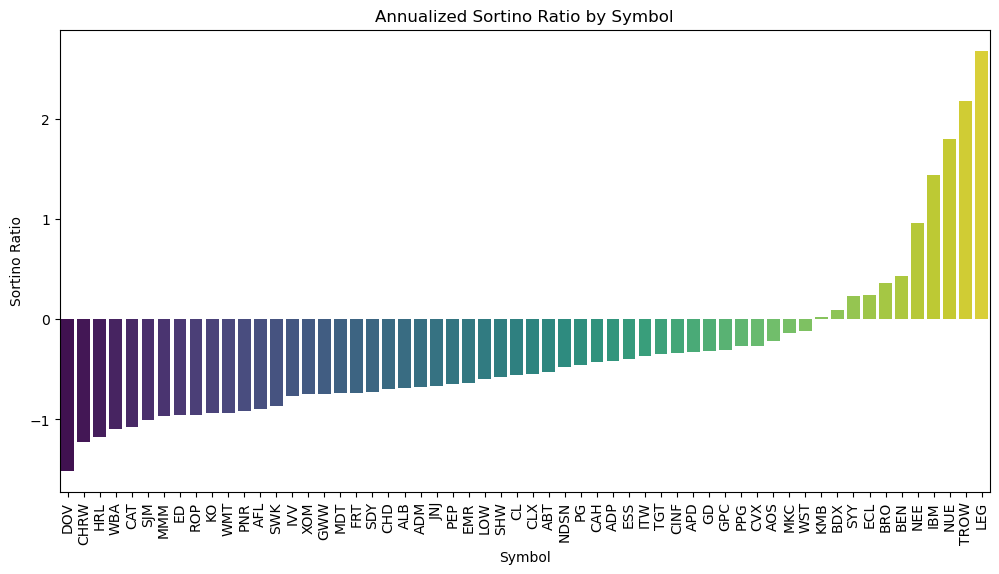

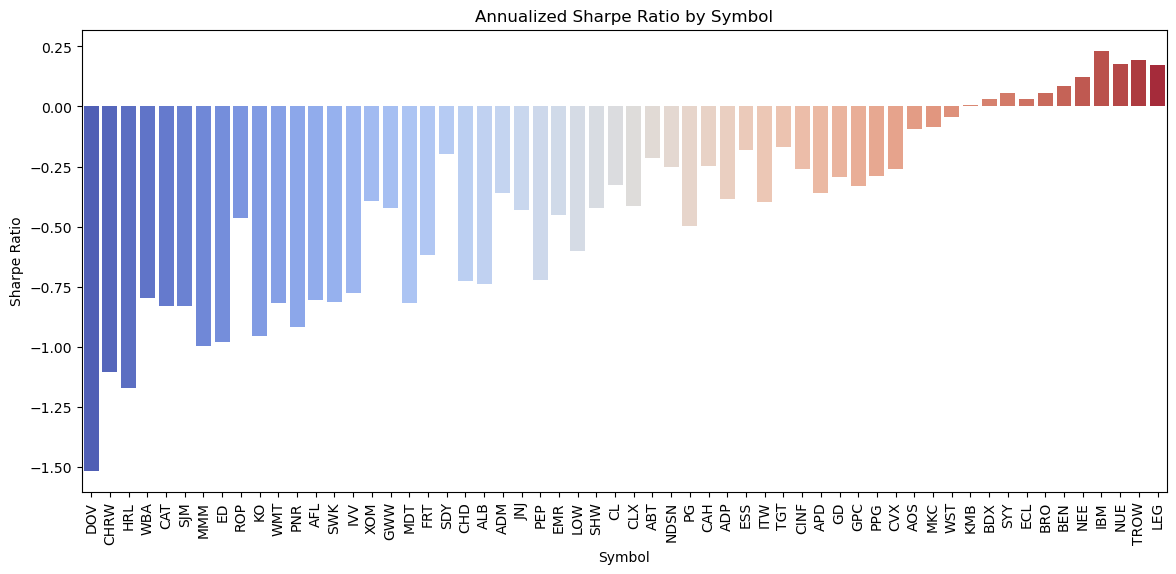

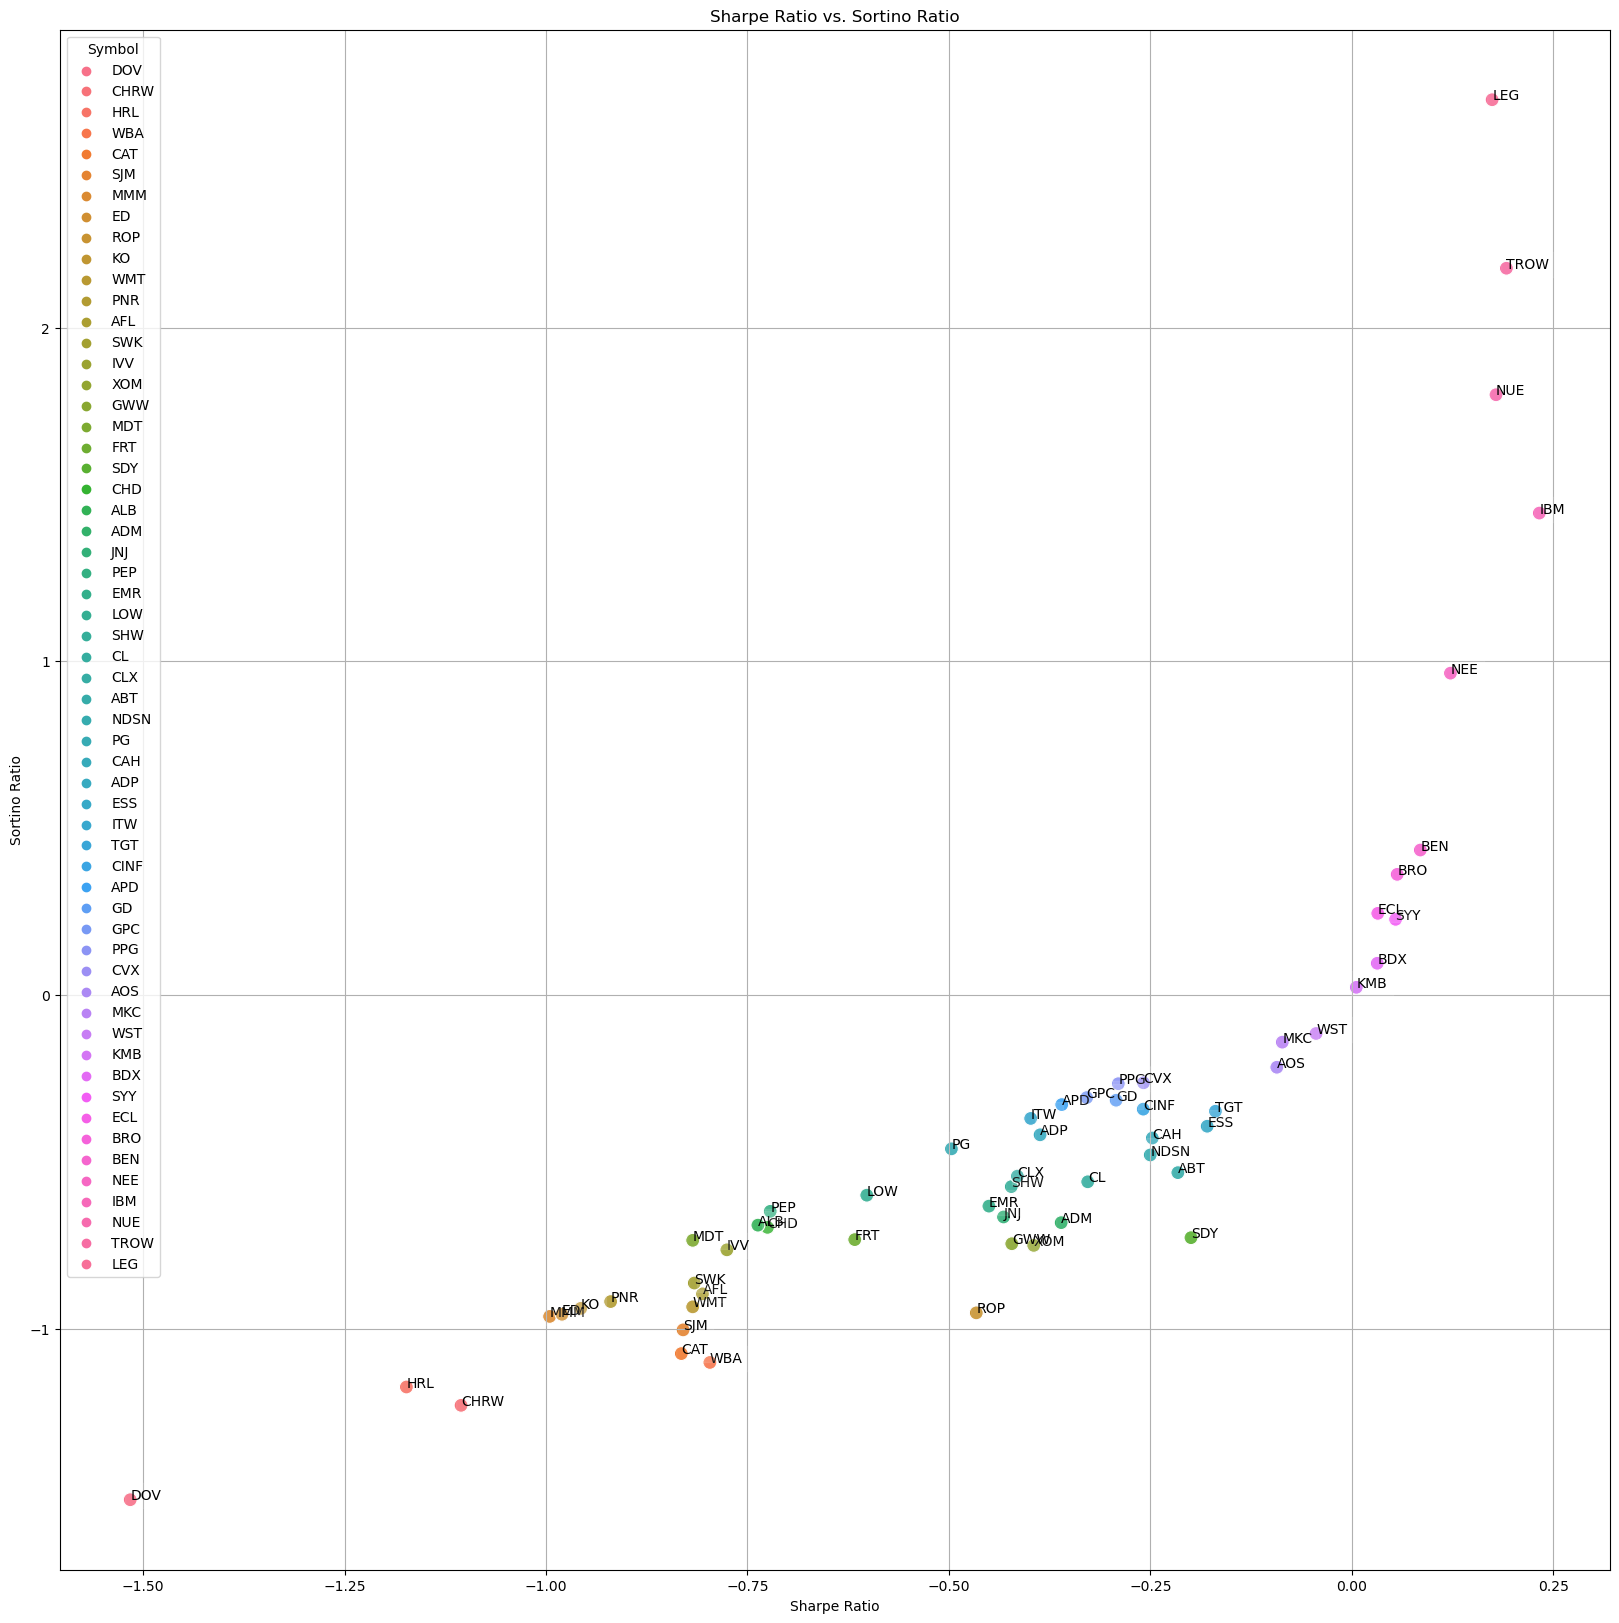

   symbol_start  mean_excess_returns  std_excess_returns     ff_avg  \
21          DOV            -2.368050            5.411380   0.438850   
13         CHRW            -2.255049            7.066927   1.182605   
30          HRL            -2.693890            7.954227   1.499035   
57          WBA            -1.648514            7.168343   0.573721   
11          CAT            -1.482729            6.172907   0.581742   
52          SJM            -2.139291            8.929808  -0.583595   
41          MMM            -2.483850            8.643490   0.662875   
23           ED            -2.280028            8.058123  -0.252815   
49          ROP            -1.123602            8.351406  -0.815226   
36           KO            -2.396016            8.674331   0.148968   
58          WMT            -2.498376           10.580347   0.666265   
47          PNR            -2.537589            9.557089   0.031879   
3           AFL            -2.121290            9.118929  -1.132874   
53    

In [79]:
# SHARPE & SORTINO MONTHLY/ANNUALIZED!

ff_final = pd.read_csv("ff_final.csv")
#print(ff_final[ff_final["symbol_start"]=="DA Selected - DCS Optimal"].head(50))
#print(ff_final[ff_final["symbol_start"]=="DA ALL - B&H (SDY)"])
AFL = ff_final[ff_final["symbol_start"]=="AFL"]
print(AFL.info())
print(AFL.head(50))

#print(ff_final[ff_final["symbol_start"] == "DA Selected - DCS Optimal"].head(50))
#print(ff_final[ff_final["symbol_start"] == "DA Selected - DCS Optimal"].tail(50))

# Group by 'symbol_start' and calculate the mean of 'excess_returns'
ff_final_consolidated = ff_final.groupby("symbol_start").agg(
    mean_excess_returns=("excess_returns", "mean"),
    std_excess_returns=("excess_returns", "std"),
    ff_avg=("F&F Avg", "mean")
).reset_index()

# Calculate downside deviation for Sortino ratio
negative_excess_returns = ff_final[ff_final["excess_returns"] < 0]

# Calculate the standard deviation of the downside deviation
downside_deviation = negative_excess_returns.groupby("symbol_start").agg(
    downside_std=("excess_returns", lambda x: np.sqrt((x**2).mean()))
).reset_index()

# Merge downside deviation into the consolidated DataFrame
ff_final_consolidated = pd.merge(
    ff_final_consolidated, downside_deviation, on='symbol_start', how='left'
)

# Annualize mean excess returns
ff_final_consolidated["annualized_mean_excess_returns"] = ff_final_consolidated[
    "mean_excess_returns"] * 12

# Annualize standard deviation of the downside
ff_final_consolidated["annualized_downside_std"] = ff_final_consolidated[
    "downside_std"] * np.sqrt(12)

# Calculate annualized Sortino ratio
ff_final_consolidated["sortino_ratio"] = (
    ff_final_consolidated["annualized_mean_excess_returns"] / ff_final_consolidated[
        "annualized_downside_std"]
)

# Annualize standard deviation of excess returns
ff_final_consolidated["annualized_std_excess_returns"] = ff_final_consolidated[
    "std_excess_returns"] * np.sqrt(12)

# Calculate annualized Sharpe ratio
ff_final_consolidated["sharpe_ratio"] = (
    ff_final_consolidated["annualized_mean_excess_returns"] / ff_final_consolidated[
        "annualized_std_excess_returns"]
)


ff_final_consolidated = ff_final_consolidated.sort_values(by = ["sortino_ratio"], ascending = True)
#print(ff_final_consolidated)
# Display the DataFrame with the new columns
#print(ff_final_consolidated)


#####################################################################################

to_drop = ["SP 500 - B&H (IVV)", "DA ALL - B&H (SDY)", "DA Selected - B&H", 
           "DA Selected - DCS Halfway", "DA Selected - DCS Optimal"]

# Create a boolean mask where True indicates rows to keep
mask = ~ff_final_consolidated['symbol_start'].isin(to_drop)

# Apply the mask to the DataFrame to keep only the rows that do not match the list
ff_final_consolidated = ff_final_consolidated[mask]
#print(ff_final_consolidated)
#####################################################################################


# Visualization of the Ratios

# Sortino Ratio
plt.figure(figsize=(12, 6))
sns.barplot(x='symbol_start', y='sortino_ratio', data=ff_final_consolidated, palette='viridis')
plt.title('Annualized Sortino Ratio by Symbol')
plt.xlabel('Symbol')
plt.ylabel('Sortino Ratio')
plt.xticks(rotation=90)
plt.show()
plt.close()

# Sharpe Ratio
plt.figure(figsize=(14, 6))
sns.barplot(x='symbol_start', y='sharpe_ratio', data=ff_final_consolidated, palette='coolwarm')
plt.title('Annualized Sharpe Ratio by Symbol')
plt.xlabel('Symbol')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=90)
plt.show()
plt.close()

# Scatter Plot of Sharpe vs Sortino Ratios
plt.figure(figsize=(20, 20))
scatter = sns.scatterplot(x='sharpe_ratio', y='sortino_ratio', data=ff_final_consolidated, hue='symbol_start', s=100)

# Add labels to each point
for i in range(ff_final_consolidated.shape[0]):
    plt.text(
        x=ff_final_consolidated['sharpe_ratio'].iloc[i], 
        y=ff_final_consolidated['sortino_ratio'].iloc[i], 
        s=ff_final_consolidated['symbol_start'].iloc[i],
        fontdict=dict(color='black', size=10),
        bbox=dict(facecolor='white', alpha=0.1, edgecolor='white')
    )

plt.title('Sharpe Ratio vs. Sortino Ratio')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Sortino Ratio')
plt.legend(title='Symbol')
plt.grid(True)
plt.show()
plt.close()


ff_final_consolidated["s_s"] = ff_final_consolidated["sharpe_ratio"] + ff_final_consolidated["sharpe_ratio"]

# Find the minimum and maximum values
min_value = ff_final_consolidated["s_s"].min()
max_value = ff_final_consolidated["s_s"].max()

# Shift the values to make the minimum value 0
ff_final_consolidated['Shifted'] = ff_final_consolidated["s_s"] - min_value

# Scale the values to set the minimum to 100 and preserve the range
range_value = ff_final_consolidated['Shifted'].max()  # this is equivalent to max_value - min_value
ff_final_consolidated['Sharpe & Sortino'] = 100 + (ff_final_consolidated['Shifted'] / range_value * 100)

# Drop the intermediate 'Shifted' column
ff_final_consolidated.drop(columns=['Shifted'], inplace=True)
print(ff_final_consolidated)

ff_final_consolidated.to_csv("ff_final_consolidated.csv")
ss = pd.read_csv("ff_final_consolidated.csv")


       Unnamed: 0.1               symbol_start year_month  stock_returns  \
0                 0                        ABT    2006-01       1.343923   
1                 1                        ABT    2006-02       0.339192   
2                 2                        ABT    2006-03      -0.480529   
3                 3                        ABT    2006-04       0.185831   
4                 4                        ABT    2006-05       0.120176   
...             ...                        ...        ...            ...   
13159         13159  DA Selected - DCS Optimal    2023-08       0.000000   
13160         13160  DA Selected - DCS Optimal    2023-09       0.000000   
13161         13161  DA Selected - DCS Optimal    2023-10       0.000000   
13162         13162  DA Selected - DCS Optimal    2023-11       0.000000   
13163         13163  DA Selected - DCS Optimal    2023-12       0.000000   

       close_adjusted_start  Unnamed: 0  Mkt-RF   SMB   HML   RMW   CMA   RF  \
0      

C:\Users\jonat\AppData\Local\Temp\ipykernel_3836\3936423119.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_df["F&F Avg"] = results_df.mean(axis=1)


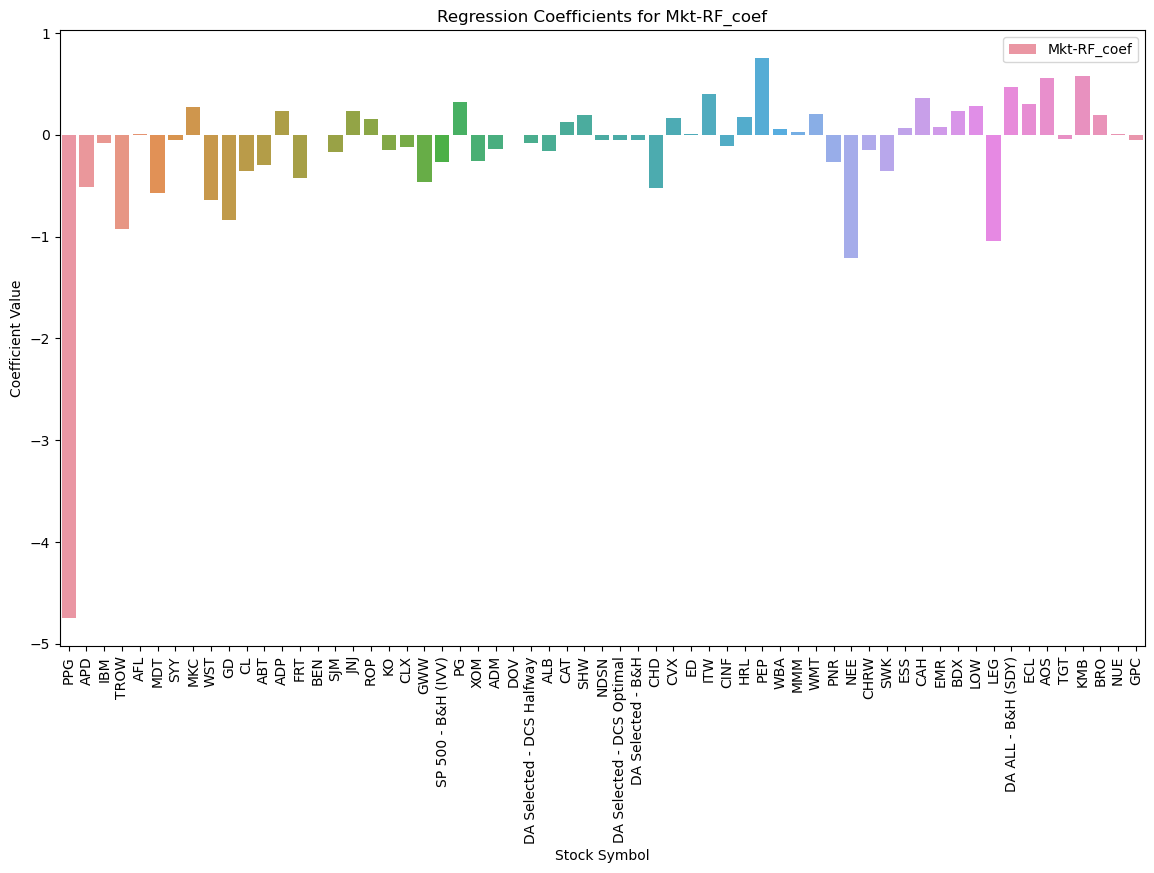

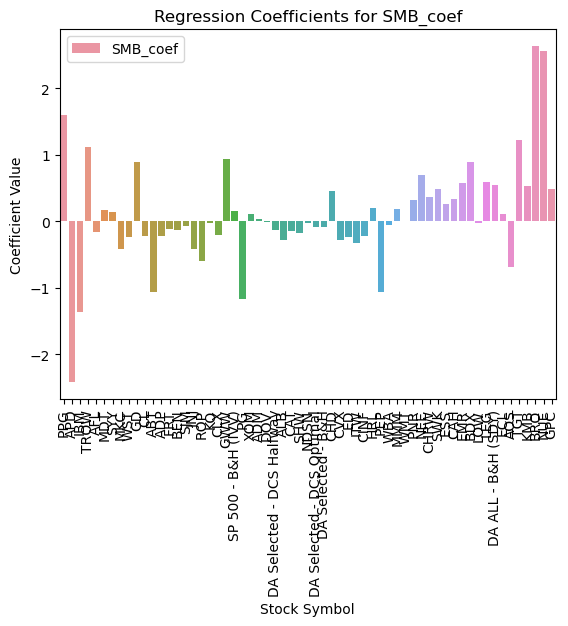

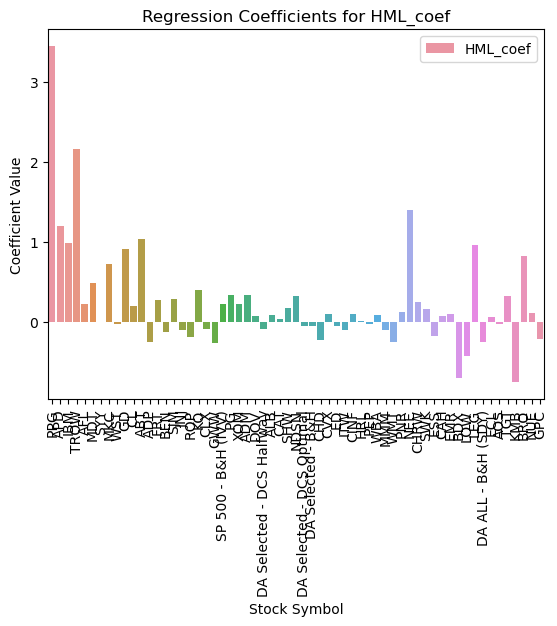

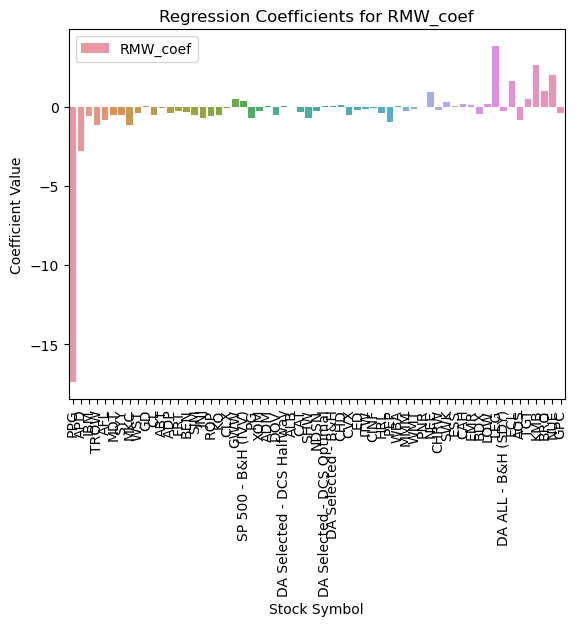

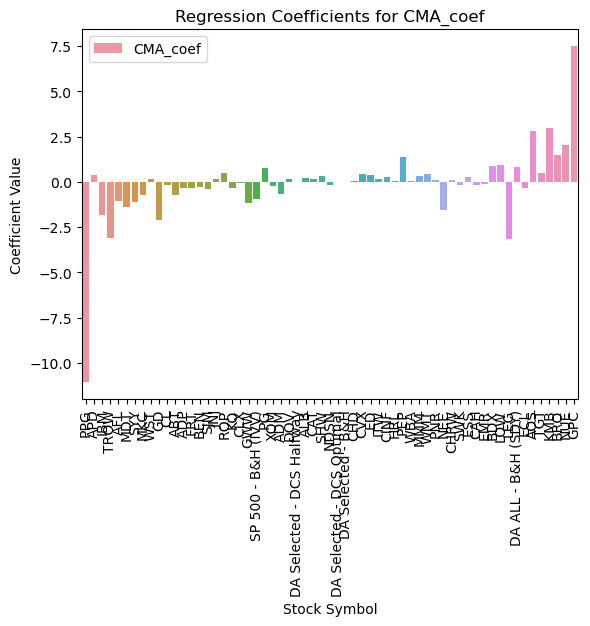

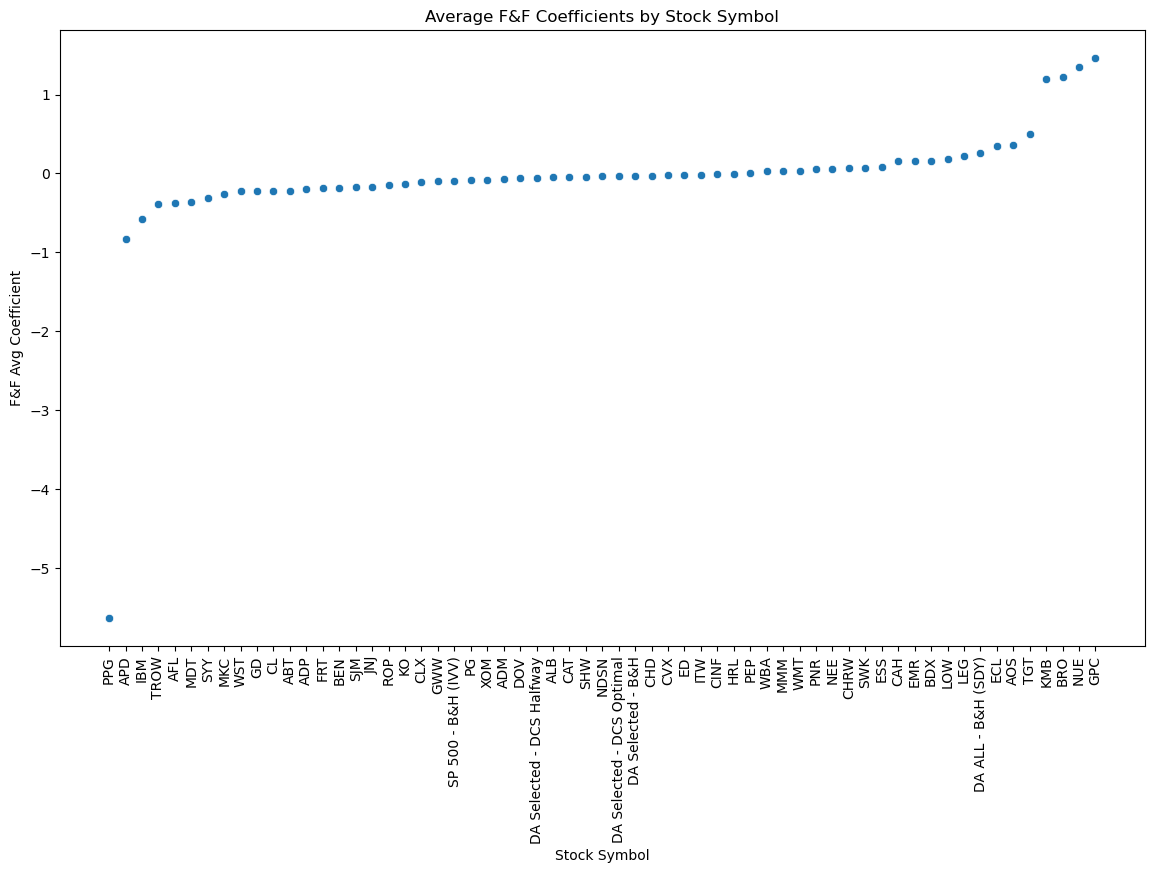

          stock_symbol  Mkt-RF_coef  SMB_coef  HML_coef  RMW_coef  CMA_coef  \
50  DA ALL - B&H (SDY)      0.47175  0.546254 -0.244059 -0.293783  0.795608   

     F&F Avg  
50  0.255154  
Empty DataFrame
Columns: [stock_symbol, Mkt-RF_coef, SMB_coef, HML_coef, RMW_coef, CMA_coef, F&F Avg]
Index: []


In [78]:
# Fama French 5-Factor Model REGRESSION MODEL AND SUMMARY OF ANALYSIS

#
ff_final = ff_final.fillna(0)
print(ff_final)
# Step 1: Group the data by month and stock symbol
grouped_data = ff_final.groupby(['year_month', 'symbol_start'])

# Step 2: Fit regression models for each stock
results = []

#
for stock_symbol, stock_data in ff_final.groupby('symbol_start'):
    X = stock_data[['Mkt-RF', 'SMB', 'HML', "RMW", "CMA"]]  # Factors as predictors
    y = stock_data['excess_returns']  # Excess returns as target variable
    
    model = sm.OLS(y, X).fit()
    results.append({'stock_symbol': stock_symbol, 'params': model.params})

# Step 3: Analyze results
results_df = pd.DataFrame(results)

# Separate the parameters into individual columns
results_df[['Mkt-RF_coef', 'SMB_coef', 'HML_coef', 'RMW_coef', 'CMA_coef']] = results_df[
    'params'].apply(pd.Series)

# Drop the 'params' column
results_df.drop(columns=['params'], inplace=True)

#
results_df["F&F Avg"] = results_df.mean(axis=1)
results_df = results_df.sort_values(by=["F&F Avg"])
   
# Rename specific cells in the "symbol_start" column
results_df["stock_symbol"] = results_df["stock_symbol"].replace(
    {"IVV": "SP 500 - B&H (IVV)", "SDY": "DA ALL - B&H (SDY)"})


#####################################################################################

#to_drop = ["SP 500 - B&H (IVV)", "DA ALL - B&H (SDY)", "DA Selected - B&H", 
 #          "DA Selected - DCS Halfway", "DA Selected - DCS Optimal"]

# Create a boolean mask where True indicates rows to keep
#mask = ~results_df['stock_symbol'].isin(to_drop)

# Apply the mask to the DataFrame to keep only the rows that do not match the list
#results_df = results_df[mask]

#to_drop = ["DA Selected - DCS Halfway"]

# Create a boolean mask where True indicates rows to keep
#mask = ~results_df['stock_symbol'].isin(to_drop)

# Apply the mask to the DataFrame to keep only the rows that do not match the list
#results_df = results_df[mask]

#####################################################################################


# Visualize the results
plt.figure(figsize=(14, 8))

# Bar plot of regression coefficients
coefficients = ['Mkt-RF_coef', 'SMB_coef', 'HML_coef', 'RMW_coef', 'CMA_coef']
for coef in coefficients:
    sns.barplot(x='stock_symbol', y=coef, data=results_df, label=coef)
    plt.xticks(rotation=90)
    plt.title(f'Regression Coefficients for {coef}')
    plt.xlabel('Stock Symbol')
    plt.ylabel('Coefficient Value')
    plt.legend()
    plt.show()
    plt.close()

# Scatter plot of average coefficient vs. stock symbol
plt.figure(figsize=(14, 8))
sns.scatterplot(x='stock_symbol', y='F&F Avg', data=results_df)
plt.xticks(rotation=90)
plt.title('Average F&F Coefficients by Stock Symbol')
plt.xlabel('Stock Symbol')
plt.ylabel('F&F Avg Coefficient')
plt.show()
plt.close()

print(results_df[results_df["stock_symbol"]=="DA ALL - B&H (SDY)"])
print(results_df[results_df["stock_symbol"]=="SDY"])


# Find the minimum and maximum values
min_value = results_df["F&F Avg"].min()
max_value = results_df["F&F Avg"].max()

# Shift the values to make the minimum value 0
results_df['Shifted'] = results_df["F&F Avg"] - min_value

# Scale the values to set the minimum to 100 and preserve the range
range_value = results_df['Shifted'].max()  # this is equivalent to max_value - min_value
results_df['Fama & French'] = 100 + (results_df['Shifted'] / range_value * 100)

# Drop the intermediate 'Shifted' column
results_df.drop(columns=['Shifted'], inplace=True)

results_df.to_csv("results_df.csv")

#SP 500 - B&H (IVV) 
#


    Unnamed: 0_x symbol  Mkt-RF_coef  SMB_coef  HML_coef   RMW_coef  \
0              0    ABT    -0.294758 -1.057517  1.036644  -0.072737   
1              1    ADM    -0.142777  0.034449  0.335443   0.055026   
2              2    ADP     0.231940 -0.213032 -0.243048  -0.403301   
3              3    AFL     0.009666 -0.153518  0.229052  -0.865311   
4              4    ALB    -0.158830 -0.284932  0.090768  -0.047627   
5              5    AOS     0.557152 -0.688202 -0.024641  -0.860516   
6              6    APD    -0.511365 -2.419440  1.194375  -2.807189   
7              7    BDX     0.229759  0.895429 -0.697192  -0.498065   
8              8    BEN     0.002032 -0.125657 -0.121919  -0.364816   
9              9    BRO     0.192845  2.633633  0.829141   0.948679   
10            10    CAH     0.358888  0.339946  0.080284   0.151685   
11            11    CAT     0.122321 -0.145372  0.040409  -0.363902   
12            12    CHD    -0.519918  0.456297 -0.221499   0.091284   
13    

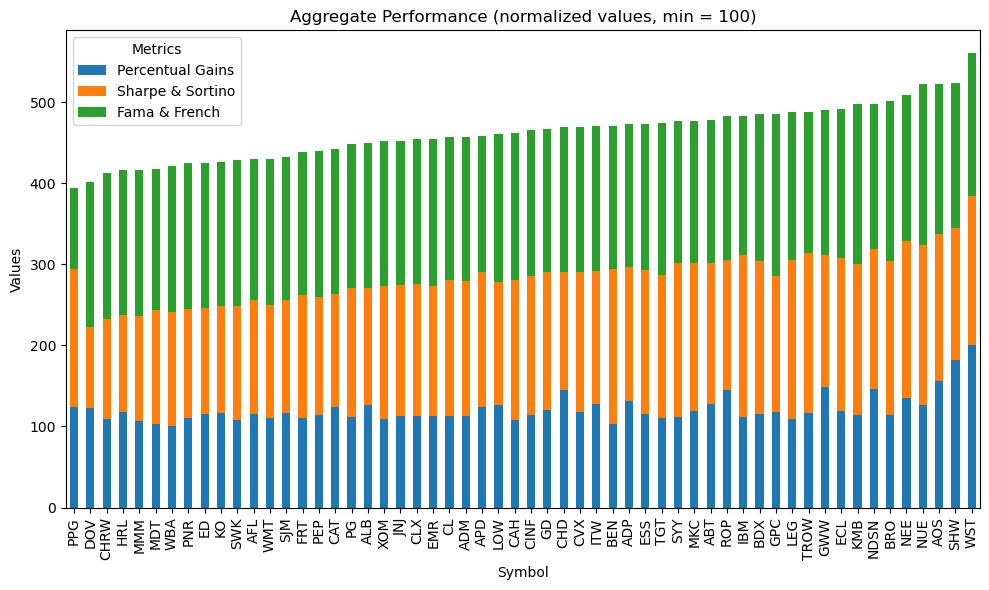

In [84]:
pg = pd.read_csv("last_percentage_gains.csv")
pg = pg.sort_values(by = ["symbol"])

ss = pd.read_csv("ff_final_consolidated.csv")
ss = ss.rename(columns = {"symbol_start":"symbol"})
ss = ss.sort_values(by = ["symbol"])

ff = pd.read_csv("results_df.csv")
ff = ff.rename(columns = {"stock_symbol":"symbol"})
ff = ff.sort_values(by = ["symbol"])

# Merge df1 and df2 on 'symbol'
pg_ss = pd.merge(pg, ss, on = 'symbol')

# Merge the resulting DataFrame with df3 on 'symbol'
agg_perf = pd.merge(ff, pg_ss, on = 'symbol')
#print(pg)
#print(ss)
#print(ff)
print(agg_perf)

# Set 'symbol' as the index
agg_perf.set_index('symbol', inplace = True)

# Select the columns to plot
columns_to_plot = ['Percentual Gains', 'Sharpe & Sortino', 'Fama & French']

agg_perf["pg_ss_ff"] = agg_perf['Percentual Gains'] + agg_perf[
    'Sharpe & Sortino'] + agg_perf['Fama & French']

agg_perf = agg_perf.sort_values(by = ["pg_ss_ff"], ascending = True) 

# Create the stacked bar plot
agg_perf[columns_to_plot].plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the plot
plt.xlabel('Symbol')
plt.ylabel('Values')
plt.title('Aggregate Performance (normalized values, min = 100)')
plt.legend(title='Metrics')
plt.tight_layout()

# Show the plot
plt.show()
plt.close()


      Unnamed: 0 year_month               symbol_start  stock_returns
864          864    2006-01  DA Selected - DCS Optimal       0.000000
865          865    2006-02  DA Selected - DCS Optimal       0.000000
866          866    2006-03  DA Selected - DCS Optimal       0.000000
867          867    2006-04  DA Selected - DCS Optimal       0.000000
868          868    2006-05  DA Selected - DCS Optimal       0.000000
...          ...        ...                        ...            ...
1075        1075    2023-08  DA Selected - DCS Optimal    6787.453923
1076        1076    2023-09  DA Selected - DCS Optimal    6884.944108
1077        1077    2023-10  DA Selected - DCS Optimal    6499.482182
1078        1078    2023-11  DA Selected - DCS Optimal    6499.482182
1079        1079    2023-12  DA Selected - DCS Optimal    6844.110157

[216 rows x 4 columns]
      Unnamed: 0 year_month               symbol_start  stock_returns  \
432          432    2006-01  DA Selected - DCS Halfway       0.

C:\Users\jonat\AppData\Local\Temp\ipykernel_1012\1728584677.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcs_drawdown["max_drawdown"] = dcs_drawdown[
C:\Users\jonat\AppData\Local\Temp\ipykernel_1012\1728584677.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_dcs_drawdown["max_drawdown"] = non_dcs_drawdown["stock_returns"]


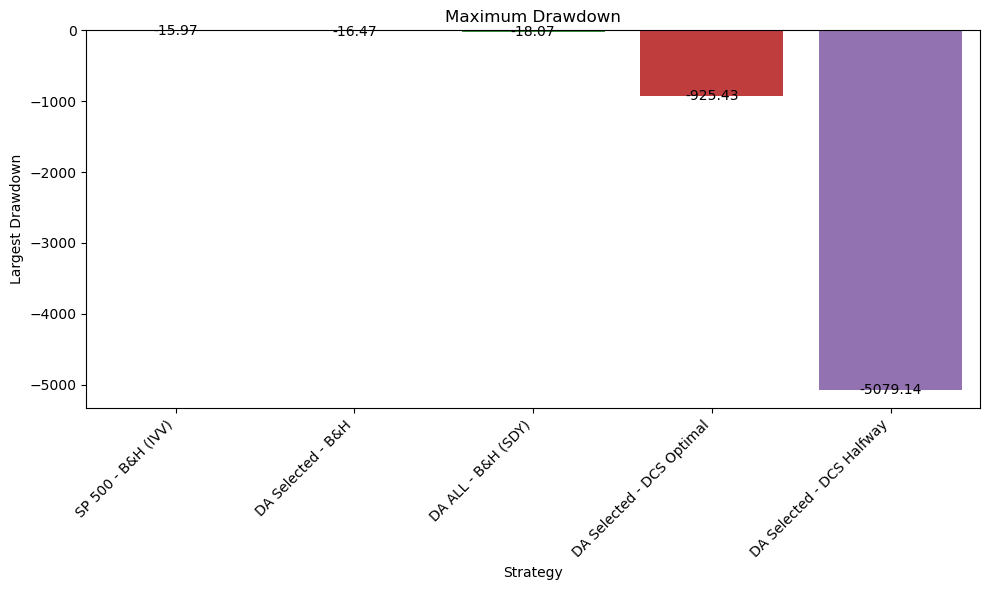

In [52]:
# MAX DRAWDOWN

all_perf_max_drawdown = pd.read_csv("all_perf_max_drawdown.csv")
print(all_perf_max_drawdown[all_perf_max_drawdown["symbol_start"]=="DA Selected - DCS Optimal"])

#
# Filter rows based on both conditions
dcs_drawdown = all_perf_max_drawdown[
    (all_perf_max_drawdown["symbol_start"] == "DA Selected - DCS Optimal") |
    (all_perf_max_drawdown["symbol_start"] == "DA Selected - DCS Halfway")]

#
dcs_drawdown["max_drawdown"] = dcs_drawdown[
    "stock_returns"] - dcs_drawdown["stock_returns"].shift(1)

# Filter rows based on both conditions
non_dcs_drawdown = all_perf_max_drawdown[
    (all_perf_max_drawdown["symbol_start"] == "SP 500 - B&H (IVV)") |
    (all_perf_max_drawdown["symbol_start"] == "DA ALL - B&H (SDY)") |
    (all_perf_max_drawdown["symbol_start"] == "DA Selected - B&H")]

non_dcs_drawdown["max_drawdown"] = non_dcs_drawdown["stock_returns"]

all_perf_max_drawdown = pd.concat([dcs_drawdown,non_dcs_drawdown], axis = 0)

print(all_perf_max_drawdown)


# Pivot the DataFrame to have portfolios as columns and years as index
pivot_perf = all_perf_max_drawdown.pivot(
    index = 'year_month', columns = 'symbol_start', values = 'max_drawdown')

# Find the smallest number (largest drawdown) for each portfolio
largest_drawdowns = pivot_perf.min()

# Find the year when the smallest number (largest drawdown) occurs for each portfolio
month_of_largest_drawdown = pivot_perf.idxmin()

# Combine the results into a DataFrame
result_max_drawdown = pd.DataFrame(
    {'Largest Drawdown': largest_drawdowns, 'Month of Largest Drawdown': month_of_largest_drawdown})

#
result_max_drawdown = pd.DataFrame(result_max_drawdown)
#result_max_drawdown.set_index('symbol_start', inplace=True)

#
result_max_drawdown = result_max_drawdown.sort_values(by = ["Largest Drawdown"], ascending = False) 

# Reset the index to make 'symbol_start' a column again
c = result_max_drawdown.reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='symbol_start', y='Largest Drawdown', data=c)

# Add title and labels
plt.title('Maximum Drawdown')
plt.xlabel('Strategy')
plt.ylabel('Largest Drawdown')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit everything

# Add the values on top of the bars
for i in range(len(c)):
    plt.text(i, c['Largest Drawdown'].iloc[i] + (
        0.01 if c['Largest Drawdown'].iloc[i] > 0 else -0.01),
             f"{c['Largest Drawdown'].iloc[i]:.2f}", ha='center',
             va='center' if c['Largest Drawdown'].iloc[i] > 0 else 'center')

plt.show()
plt.close()



In [32]:
# INDIVIDUAL SYMBOLS: SHARPE AND SORTINO RATIOS

print(ff_final_consolidated.head(50))

#ff_final_consolidated = ff_final_consolidated.drop(columns = ["beta_x", "beta_y"])

#print(ff_final_consolidated)
beta_avg = beta_avg.rename(columns = {"symbol": "symbol_start"})

#ff_final_consolidated = pd.concat([ff_final_consolidated, beta_avg], axis = 1)
ff_final_consolidated = ff_final_consolidated.merge(beta_avg, on = "symbol_start", how = "outer")

#print(ff_final_consolidated.head(50))


#--------------------------------------------------------------------------------------

# Extract the single average beta value from the beta calculation of the DCS portfolio
beta_avg_dcs = beta_avg_dcs['beta_dcs'].iloc[0]

#--------------------------------------------------------------------------------------


# Fill NaN values in the 'beta' column with the average beta value
ff_final_consolidated['beta'] = ff_final_consolidated['beta'].fillna(beta_avg_dcs)
print(ff_final_consolidated.head(50))

# Remove duplicate columns
ff_final_consolidated = ff_final_consolidated.loc[:, ~ff_final_consolidated.columns.duplicated()]

#ff_final_consolidated.drop(columns = ["symbol_start"], inplace = True)
#print(ff_final_consolidated)
selected_columns = ["symbol_start", "ff_avg", "mean_excess_returns", "sortino_ratio", "sharpe_ratio"]
ff_final_consolidated = ff_final_consolidated[selected_columns]

# Rename columns
ff_final_consolidated = ff_final_consolidated.rename(
    columns = {"symbol_start": "Strategy", "mean_excess_returns": "Excess Returns", 
               "sortino_ratio": "Sortino","sharpe_ratio": "Sharpe"})

# Remove the old index and sort by 'sortino_ratio' in descending order
ff_final_consolidated = ff_final_consolidated.sort_values(
    by = "Sortino", ascending = False).reset_index(drop = True)

# Rename specific cells in the "Strategy" column
ff_final_consolidated["Strategy"] = ff_final_consolidated["Strategy"].replace(
    {"IVV": "SP 500 - B&H (IVV)", "SDY": "DA ALL - B&H (SDY)"})

#print(portfolio_std.head(20))

# Filter the DataFrame to include only the specified portfolios
portfolios = [
    "DA Selected - B&H", "DA Selected - DCS Halfway", 
    "DA Selected - DCS Optimal", "SP 500 - B&H (IVV)", "DA ALL - B&H (SDY)"]

ff_portfolios = ff_final_consolidated[ff_final_consolidated["Strategy"].isin(portfolios)]

# Sort the filtered DataFrame by 'F&F Avg' in descending order
ff_portfolios = ff_portfolios.sort_values(by = "ff_avg", ascending = False).reset_index(drop = True)

# Sort the filtered DataFrame by 'Sortino' in descending order
sortino_portfolios = ff_portfolios.sort_values(
    by = "Sortino", ascending = False).reset_index(drop = True)

# Rename specific cells in the "symbol_start" column
ff_final_consolidated["Strategy"] = ff_final_consolidated["Strategy"].replace(
    {"IVV": "SP 500 - B&H (IVV)", "SDY": "DA ALL - B&H (SDY)"})

print(ff_final_consolidated.head(20))

# Remove the old index and sort by 'sortino_ratio' in descending order
portfolios = [
    "DA Selected - B&H", "DA Selected - DCS Halfway", 
    "DA Selected - DCS Optimal", "SP 500 - B&H (IVV)", "DA ALL - B&H (SDY)"]

ff_portfolios = ff_final_consolidated

# Filter the DataFrame to include only the specified portfolios
ff_portfolios = ff_portfolios[ff_portfolios["Strategy"].isin(portfolios)]

ff_portfolios = ff_portfolios.sort_values(by = "ff_avg", ascending = False).reset_index(drop = True)

sortino_portfolios = ff_portfolios.sort_values(by = "Sortino", ascending = False).reset_index(
    drop = True)

sharpe_portfolios = ff_portfolios

sharpe_portfolios = ff_portfolios.sort_values(by = "Sharpe", ascending = False).reset_index(
    drop = True)

avg_ff_portfolios = ff_portfolios.sort_values(by = "ff_avg", ascending = False).reset_index(
    drop = True)

print(ff_portfolios)
print(sortino_portfolios)

                 symbol_start  mean_excess_returns  std_excess_returns  \
31                        IBM             3.183525           47.421920   
56                       TROW             3.072137           55.508703   
44                        NUE             2.868546           55.570343   
37                        LEG             3.355897           66.813706   
43                        NEE             0.989016           28.011226   
8                         BEN             0.595549           24.297972   
9                         BRO             0.685281           42.235604   
54                        SYY             0.377377           24.112731   
22                        ECL             0.296992           32.026877   
7                         BDX             0.218169           24.016784   
35                        KMB             0.050065           31.700544   
59                        WST            -0.311194           24.264226   
40                        MKC         

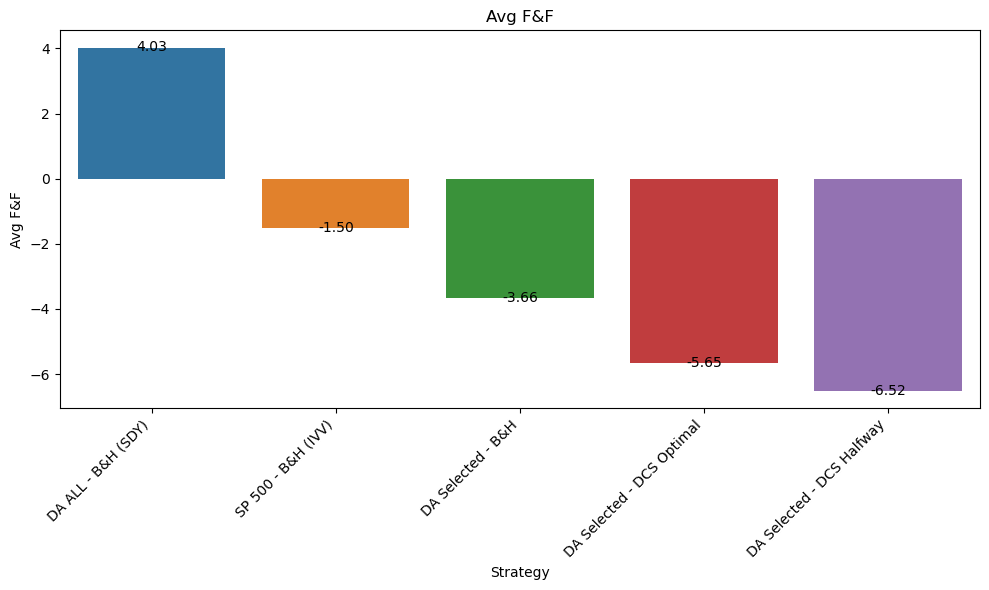

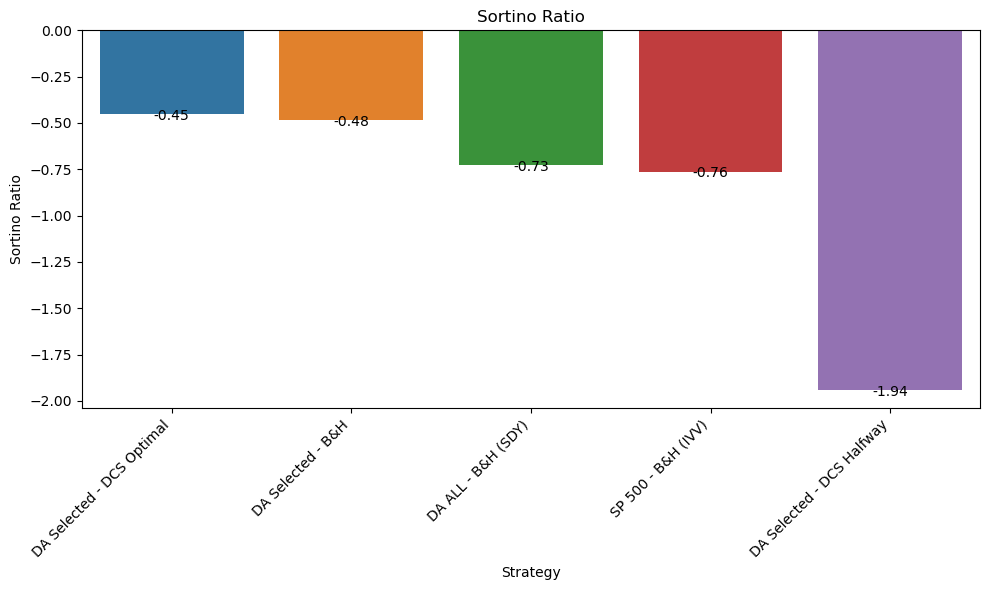

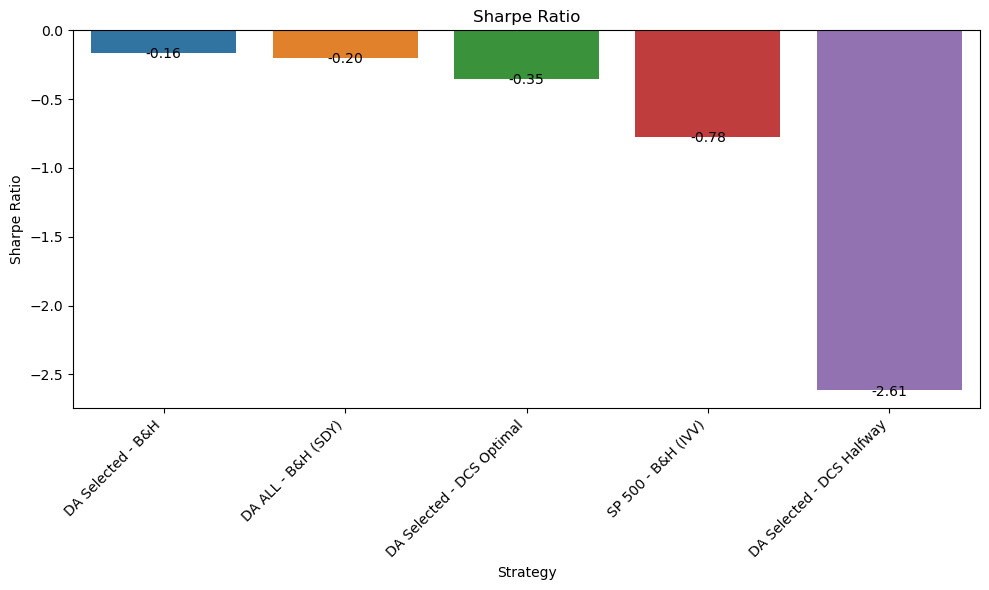

In [53]:
# SORTINO AND SHARPE VISUALIZATION

# F&F
#print(ff_portfolios)
ff_portfolios = pd.DataFrame(ff_portfolios)

#ff_portfolios = ff_portfolios.set_index('Strategy', inplace=True)

ff_portfolios = ff_portfolios.sort_values(by = ["ff_avg"], ascending = False) 

# Reset the index to make 'symbol_start' a column again
#ff_portfolios = ff_portfolios.reset_index()
# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Strategy', y='ff_avg', data=ff_portfolios)

# Add title and labels
plt.title('Avg F&F')
plt.xlabel('Strategy')
plt.ylabel('Avg F&F')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit everything

# Add the correlation values on top of the bars
for i in range(len(ff_portfolios)):
    plt.text(i, ff_portfolios['ff_avg'].iloc[i] + (
        0.01 if ff_portfolios['ff_avg'].iloc[i] > 0 else -0.01), 
             f"{ff_portfolios['ff_avg'].iloc[i]:.2f}", ha = 'center', 
             va = 'center' if ff_portfolios['ff_avg'].iloc[i] > 0 else 'center')

plt.show()
plt.close()



# SORTINO

sortino_portfolios = pd.DataFrame(sortino_portfolios)
#result_max_drawdown.set_index('symbol_start', inplace=True)

sortino_portfolios = sortino_portfolios.sort_values(by = ["Sortino"], ascending = False) 

# Reset the index to make 'symbol_start' a column again
#sortino_portfolios = sortino_portfolios.reset_index()
# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Strategy', y='Sortino', data=sortino_portfolios)

# Add title and labels
plt.title('Sortino Ratio')
plt.xlabel('Strategy')
plt.ylabel('Sortino Ratio')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit everything

# Add the correlation values on top of the bars
for i in range(len(sortino_portfolios)):
    plt.text(i, sortino_portfolios['Sortino'].iloc[i] + (
        0.01 if sortino_portfolios['Sortino'].iloc[i] > 0 else -0.01), 
             f"{sortino_portfolios['Sortino'].iloc[i]:.2f}", ha = 'center', 
             va = 'center' if sortino_portfolios['Sortino'].iloc[i] > 0 else 'center')

plt.show()
plt.close()




# SHARPE

sharpe_portfolios = pd.DataFrame(sharpe_portfolios)
#result_max_drawdown.set_index('symbol_start', inplace=True)

sharpe_portfolios = sharpe_portfolios.sort_values(by = ["Sharpe"], ascending = False) 

# Reset the index to make 'symbol_start' a column again
#sortino_portfolios = sortino_portfolios.reset_index()
# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Strategy', y='Sharpe', data=sharpe_portfolios)

# Add title and labels
plt.title('Sharpe Ratio')
plt.xlabel('Strategy')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit everything

# Add the correlation values on top of the bars
for i in range(len(sharpe_portfolios)):
    plt.text(i, sharpe_portfolios['Sharpe'].iloc[i] + (
        0.01 if sharpe_portfolios['Sharpe'].iloc[i] > 0 else -0.01), 
             f"{sharpe_portfolios['Sharpe'].iloc[i]:.2f}", ha = 'center', 
             va = 'center' if sharpe_portfolios['Sharpe'].iloc[i] > 0 else 'center')

plt.show()
plt.close()



                symbol_start  correlation
0         DA ALL - B&H (SDY)     0.891769
1          DA Selected - B&H     0.775932
2  DA Selected - DCS Halfway    -0.038876
3  DA Selected - DCS Optimal     0.014512


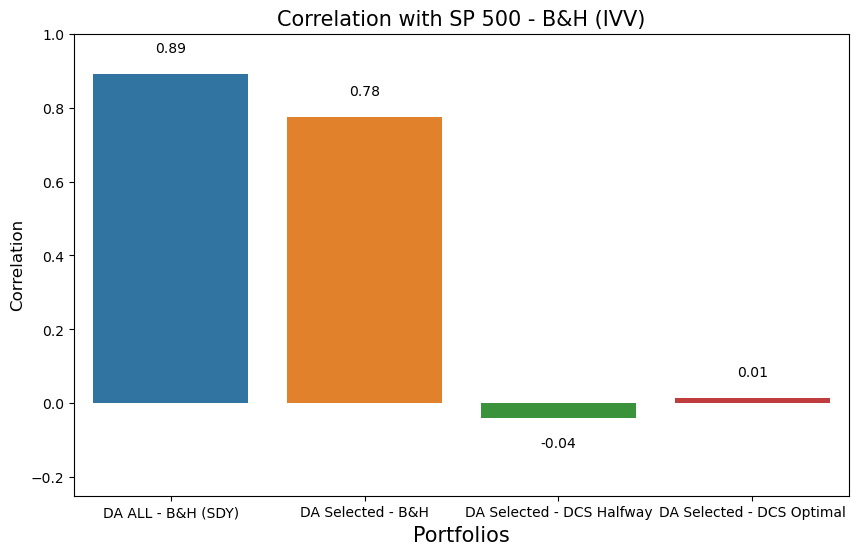

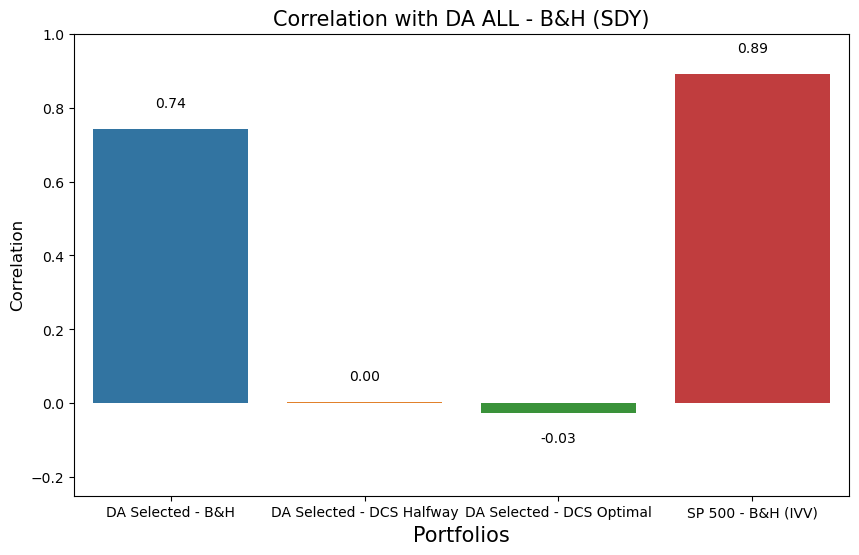

In [54]:
# CORRELATION ANALYSIS

# Pivot the DataFrame to have portfolios as columns
all_perf_pivot = all_perf_max_drawdown.pivot(
    index = 'year_month', columns = 'symbol_start', values = 'stock_returns')

# Assuming the initial DataFrame has an 'rf' column
#all_perf_pivot = all_perf_pivot.drop(columns = ['RF'])

# Calculate the correlation matrix
correlation_matrix = all_perf_pivot.corr()


# SP500 CORRELATION

# Extract the correlation for 'SP 500 - B&H (IVV)'
corr_sp500 = correlation_matrix.loc['SP 500 - B&H (IVV)']

# Convert series to DataFrame and reset index to make 'symbol_start' a column
corr_sp500_df = corr_sp500.reset_index()
corr_sp500_df.columns = ['symbol_start', 'correlation']

# Drop the row where 'symbol_start' equals 'SP 500 - B&H (IVV)'
corr_sp500_df = corr_sp500_df[corr_sp500_df['symbol_start'] != 'SP 500 - B&H (IVV)']

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='symbol_start', y='correlation', data=corr_sp500_df)

# Add title and labels
plt.title('Correlation with SP 500 - B&H (IVV)', fontsize=15)
plt.xlabel('Portfolios', fontsize=15)
plt.ylabel('Correlation', fontsize=12)
plt.ylim(-0.25, 1)  # Set the y-axis minimum to -0.25
#plt.xticks(rotation=45)
print(corr_sp500_df)
# Add the correlation values on top of the bars
for i in range(len(corr_sp500_df)):
    plt.text(i, corr_sp500_df[
        'correlation'][i] + (0.05 if corr_sp500_df['correlation'][i] > 0 else -0.05), 
             f"{corr_sp500_df['correlation'][i]:.2f}", ha = 'center', va = 'bottom' if corr_sp500_df[
                 'correlation'][i] > 0 else 'top')

plt.show()
plt.close()


# SDY CORRELATION

# Extract the correlation for 'DA ALL - B&H (SDY)'
corr_sdy = correlation_matrix['DA ALL - B&H (SDY)']

# Convert series to DataFrame and reset index to make 'symbol_start' a column
corr_sdy_df = corr_sdy.reset_index()
corr_sdy_df.columns = ['symbol_start', 'correlation']

# Drop the row where 'symbol_start' equals 'DA ALL - B&H (SDY)'
corr_sdy_df = corr_sdy_df[corr_sdy_df['symbol_start'] != 'DA ALL - B&H (SDY)']

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='symbol_start', y='correlation', data=corr_sdy_df)

# Add title and labels
plt.title('Correlation with DA ALL - B&H (SDY)', fontsize=15)
plt.xlabel('Portfolios', fontsize=15)
plt.ylabel('Correlation', fontsize=12)
plt.ylim(-0.25, 1)  # Set the y-axis minimum to -0.25
#plt.xticks(rotation=45)

# Add the correlation values on top of the bars
for i in range(len(corr_sdy_df)):
    plt.text(i, corr_sdy_df['correlation'].iloc[i] + (
        0.05 if corr_sdy_df['correlation'].iloc[i] > 0 else -0.05), 
             f"{corr_sdy_df['correlation'].iloc[i]:.2f}", ha = 'center', 
             va = 'bottom' if corr_sdy_df['correlation'].iloc[i] > 0 else 'top')

plt.show()
plt.close()


         DA Selected - DCS Optimaldollar  DA Selected - DCS Optimalperc  \
2006-01                         0.000000                       0.000000   
2006-02                         0.000000                       0.000000   
2006-03                         0.000000                       0.000000   
2006-04                        10.134226                       0.000000   
2006-05                         0.000000                       0.000000   
...                                  ...                            ...   
2023-08                         0.000000                    6787.453923   
2023-09                         9.879875                    6884.944108   
2023-10                       -39.063582                    6499.482182   
2023-11                         0.000000                    6499.482182   
2023-12                        34.925377                    6844.110157   

         DA Selected - DCS Optimalperc_adj  DA Selected - DCS Optimal  
2006-01                    

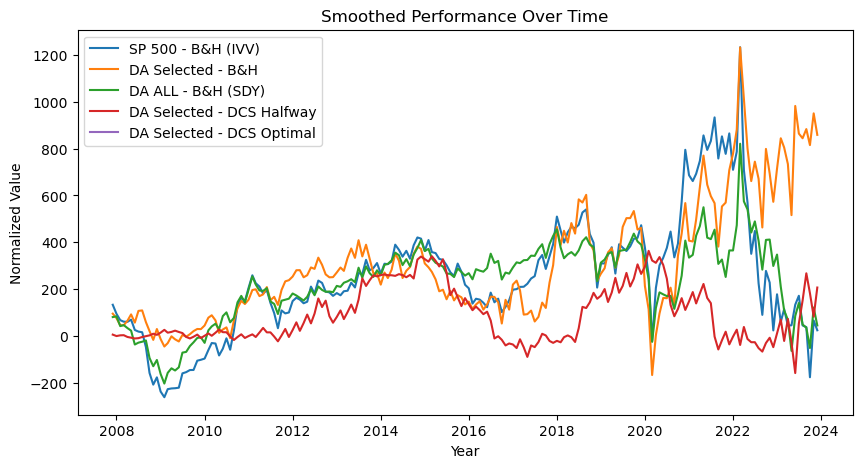

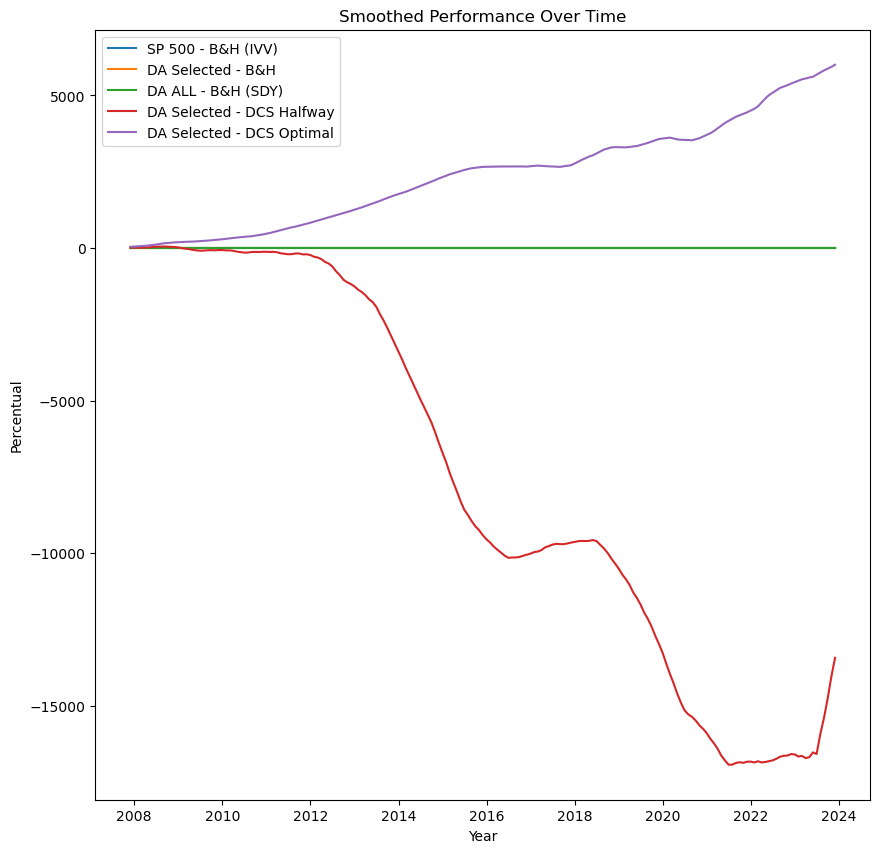

In [35]:
#  NORMALIZED AND PERCENTUAL



#DA Selected - DCS Optimal

dcs_optimal_norm = dcs_optimal

#print(dcs_optimal_norm.head(50))
dcs_optimal_norm["DA Selected - DCS Optimal"] = (
    dcs_optimal_norm["DA Selected - DCS Optimaldollar"] / dcs_optimal_norm.iloc[0][
        "DA Selected - DCS Optimaldollar"] * 100)
print(dcs_optimal_norm)



#DA Selected - DCS Halfway

final_norm = dcs_halfway
#print(dcs_halfway)
final_norm["DA Selected - DCS Halfway"] = (final_norm[
    "DA Selected - DCS Halfwaydollar"] / final_norm.iloc[0]["DA Selected - DCS Halfwaydollar"] * 100)
#print(final_norm)



#DA Selected - B&H

bh_perf_selected_final_norm = bh_perf_selected_final

# Normalize the cumulative profits and dividends by dividing by the initial value and scaling to 100
bh_perf_selected_final_norm["DA Selected - B&H"] = (bh_perf_selected_final[
        "DA Selected - B&Hdollar"] / bh_perf_selected_final.iloc[0]["DA Selected - B&Hdollar"] * 100) 
#print(bh_perf_selected_final_norm)



#SP 500 - B&H (IVV)

sp500_norm = sp500_final
#print(sp500_final)
# Normalize the cumulative profits and dividends by dividing by the initial value and scaling to 100
sp500_norm["SP 500 - B&H (IVV)"] = (sp500_final["SP 500 - B&H (IVV)dollar"] / sp500_final.iloc[0][
        "SP 500 - B&H (IVV)dollar"] * 100)



#DA ALL - B&H (SDY)

sdy_norm = bh_perf_all_final

# Normalize the cumulative profits and dividends by dividing by the initial value and scaling to 100
sdy_norm["DA ALL - B&H (SDY)"] = (bh_perf_all_final[
        "DA ALL - B&H (SDY)dollar"] / bh_perf_all_final.iloc[0]["DA ALL - B&H (SDY)dollar"] * 100)
sdy_norm = sdy_norm.resample('M').ffill()
#print(sdy_norm)
#sl_columns = ["DA ALL - B&H (SDY)"]
#sdy_norm = sdy_norm[sl_columns]


normalized = pd.concat(
    [final_norm,dcs_optimal_norm,sp500_norm,sdy_norm,bh_perf_selected_final_norm], axis = 1)

normalized = final_norm.combine_first(dcs_optimal_norm).combine_first(
    sp500_norm).combine_first(sdy_norm).combine_first(bh_perf_selected_final_norm)

#print(normalized)
    
# Apply rolling average with a window of 12 months (1 year)
window_size = 24
smoothed_normalized = normalized.rolling(window=window_size).mean()

# Convert the index from Period to datetime
smoothed_normalized.index = smoothed_normalized.index.to_timestamp()

print(smoothed_normalized)#.head(50))

# Plot smoothed data
plt.figure(figsize=(10, 5))

plt.plot(smoothed_normalized.index, smoothed_normalized[
    'SP 500 - B&H (IVV)'], label='SP 500 - B&H (IVV)')

plt.plot(smoothed_normalized.index, smoothed_normalized[
    'DA Selected - B&H'], label='DA Selected - B&H')

plt.plot(smoothed_normalized.index, smoothed_normalized[
    'DA ALL - B&H (SDY)'], label='DA ALL - B&H (SDY)')

plt.plot(smoothed_normalized.index, smoothed_normalized[
    'DA Selected - DCS Halfway'], label='DA Selected - DCS Halfway')

plt.plot(smoothed_normalized.index, smoothed_normalized[
    'DA Selected - DCS Optimal'], label='DA Selected - DCS Optimal')

plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.title('Smoothed Performance Over Time')
plt.legend()
plt.show()
plt.close()





# Plot smoothed data
plt.figure(figsize=(10, 10))

plt.plot(smoothed_normalized.index, smoothed_normalized[
    'SP 500 - B&H (IVV)perc'], label='SP 500 - B&H (IVV)')

plt.plot(smoothed_normalized.index, smoothed_normalized[
    'DA Selected - B&Hperc'], label='DA Selected - B&H')

plt.plot(smoothed_normalized.index, smoothed_normalized[
    'DA ALL - B&H (SDY)perc'], label='DA ALL - B&H (SDY)')

plt.plot(smoothed_normalized.index, smoothed_normalized[
    'DA Selected - DCS Halfwayperc'], label='DA Selected - DCS Halfway')

plt.plot(smoothed_normalized.index, smoothed_normalized[
    'DA Selected - DCS Optimalperc'], label='DA Selected - DCS Optimal')

plt.xlabel('Year')
plt.ylabel('Percentual')
plt.title('Smoothed Performance Over Time')
plt.legend()
plt.show()
plt.close()


In [ ]:
# Risk-Performance analysis of trading strategies

# Dollar-return: DONE
# CAGR: DONE
# F&F: DONE
# Sortino & Sharpe: DONE
# Drawdown: DONE
# SDY (fra 2006): DONE
# CORRELATION ML SP500 OG SDY: DONE
# Convert chart x-axes to years: DONE
# Normalized: DONE
# Percentual: DONE
# As-is "kursværdi" DONE
# Fill i stedet for interpolate!!! DONE
# Hvorfor ikke dividend i 2023?? DONE
# Er det nødv at beregne sortino/sharpe 2 gange? Differencer skal afklares!!!!!!!! DONE
# Visual sortino/sharpe DONE
# Visual F&F DONE
# Korrigere F&F & Sortino/Sharpe mht dividend - Tjek begge steder F&F beregnes!!!! DONE
# Chart / tabel med de enkelte aktiers samlede stigning (inkl dividend) DONE
# Bliver der taget højde for de årlige afkast ved DCS strategierne? Ja. DONE
# Calculate historical returns: returns = df.pct_change(1).dropna() DONE
# Market returns/BETA: "close">adjusted close? Close DONE

# Visualisere ML / statistisk analyse af patterns
# Automatisere årsinput ()


# Struktur:
#1. F&F & ratios Individual
#2. Heatmaps Individual
#3. Statistik/ML Individual
#4. Delkonklusion: Udvælg 2+2
#5. F&F & ratios portfolios
#6. Heatmaps portfolios
#7. Heatmaps portfolios
#8. Dollar gains, dollar gains acc
#9. CAGR, normalized
#10. Correlation
#11. Delonklusion
#12. Konklusion
#13. Perspektivering


# Describe Strategies
# SP 500 - B&H (IVV)
# DA ALL - B&H (SDY)
# DA Selected - B&H
# DA Selected - DCS Optimal 
# DA Selected - DCS Halfway



# REFLECTIONS:
# When applying F&F / Sortino/Sharpe to select the best shares, dcs_optimal is out-performed by other strategies. 
#However, when selecting shares that, still within top-performers (>2 sortino) with more similar price patterns,
# dcs_optimal is the best performing strategy. Note also, that the strategy has a 2.9 sortino ratio, indicating a favorable
# negative volitality-reward ratio
# Furthermore, the strategy seemingly has little or negative correlation to S&P 500 or NASDAQ, thus being a potential 
# risk-hedging strategy-although in 2022 the strategy was also negatively affected by the bear market
# This is notwithstanding the lacking statistical evidence of the intra-dividend price pattern


#Sharpe ratios are better at analyzing portfolios that have low volatility 
#while Sortino ratio is better when analyzing highly volatile portfolios.
#Usually, any Sharpe ratio greater than 1.0 is considered acceptable to good by investors
#A good Sortino ratio is one with a score of 2 or above, but some investors might accept lower ratios depending on their
#risk preferences



##########################################################################

# Further studies could investigate applying machine learning and AI to optimize the portfolio 
# and intra-dividend date trading days

# Analyze longer timeframe
# Analyze non-US dividend stocks
# Tableau
# Industry segmentation
# Trading volumen
# Dividend stock specific information such as declaration date
# Monthly




In [ ]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


In [27]:
# BETA ---- MONTHLY -----------

# Create a boolean mask where True indicates rows to keep
mask = ~ff['symbol'].isin(lst)

# Apply the mask to the DataFrame to keep only the rows that do not match the list
ff_beta = set(ff[mask]['symbol'])

# Initialize a list to accumulate results
beta_results = []

# Cache market returns to avoid redundant API calls
market_returns_cache = {}

for year in range(start_year, end_year + 1):
    market_data = yf.Ticker('^GSPC').history(start=f'{year}-01-01', end=f'{year}-12-31')
    market_data['Monthly_Return'] = market_data['Close'].resample('M').ffill().pct_change()
    market_returns_cache[year] = market_data['Monthly_Return']

for stock in ff_beta:
    for year in range(start_year, end_year + 1):
        # Fetch historical price data
        ticker = yf.Ticker(stock)
        hist_data = ticker.history(start=f'{year}-01-01', end=f'{year}-12-31')
        
        if hist_data.empty:
            continue  # Skip if no data is returned
        
        # Calculate monthly returns
        hist_data['Monthly_Return'] = hist_data['Close'].resample('M').ffill().pct_change()
        market_returns = market_returns_cache[year]
        
        # Align the data to avoid NaNs
        aligned_data = pd.concat([hist_data['Monthly_Return'], market_returns], axis=1).dropna()
        if aligned_data.empty:
            continue  # Skip if no valid data for the year
        
        cov_matrix = aligned_data.cov().iloc[0, 1]
        market_var = aligned_data.iloc[:, 1].var()
        beta_value = cov_matrix / market_var
        
        # Accumulate results in a list
        beta_results.append({'symbol': stock, 'year': year, 'beta': beta_value})

# Convert the list of results to a DataFrame
historical_beta_data = pd.DataFrame(beta_results)

# Compute the average beta per symbol
beta_avg = historical_beta_data.groupby('symbol').agg(beta=('beta', 'mean')).reset_index()

print(beta_avg)

   symbol      beta
0     ABT  0.680611
1     ADM  0.432697
2     ADP  0.844778
3     AFL  1.283341
4     AOS  1.213594
5     APD  1.221222
6     BDX  0.708618
7     BEN  1.442918
8     BRO  0.566063
9     CAH  0.865516
10    CAT  1.595234
11    CHD  0.471274
12   CHRW  0.629596
13   CINF  0.612394
14     CL  0.620755
15    CLX  0.624808
16    CVX  0.998725
17    DOV  1.212308
18    ECL  0.729481
19     ED  0.367342
20    EMR  1.324553
21    ESS  0.945992
22    FRT  0.984397
23     GD  0.937906
24    GPC  0.796691
25    GWW  1.195627
26    HRL  0.326402
27    IBM  1.073252
28    ITW  1.135762
29    JNJ  0.621221
30    KMB  0.613948
31     KO  0.455329
32    LEG  1.072126
33    LOW  1.330283
34    MDT  0.917264
35    MKC  0.495597
36    MMM  1.105036
37   NDSN  1.473981
38    NEE  0.635808
39    NUE  1.616728
40    PEP  0.342813
41     PG  0.587816
42    PNR  1.357147
43    PPG  1.392256
44    ROP  0.906608
45    SHW  1.030219
46    SJM  0.609693
47    SWK  1.517163
48    SYY  0.844672


In [16]:
# LOAD HISTORICAL DATA OF THE DIVIDEND STOCKS FROM YFINANCE

# List of SP 500 index and etf
indices = ['^GSPC', 'IVV', 'SDY']

# Add SP 500 and NASDAQ to the list of Dividend Aristocrats
stocks = da_lst + indices 

#################################################################################

# Define date range
start_date = '2006-01-01'
end_date = '2024-01-01'

#################################################################################

# Create an empty DataFrame to store historical price, dividend, closing price, and adjusted closing price data
all_data = pd.DataFrame()

# Loop through each stock symbol and download data from yfinance
for stock in stocks:
    
    # Download historical price and dividend data for the stock
    stock_data = yf.download(stock, start = start_date, end = end_date).reset_index()
    dividend_data = yf.Ticker(stock).dividends.reset_index()
    
    # Ensure date format is correct
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data['Date'] = stock_data['Date'].dt.date
    dividend_data['Date'] = pd.to_datetime(dividend_data['Date'])
    dividend_data['Date'] = dividend_data['Date'].dt.date
    
    # Merge historical price data with dividend data on date
    merged_data = pd.merge(stock_data, dividend_data, how = 'left', on = 'Date')
    
    # Add a column to identify the stock
    merged_data['Symbol'] = stock
    
    # Concatenate the data to the DataFrame
    all_data = pd.concat([all_data, merged_data])

# Save the data to a CSV file
all_data.to_csv('historical_prices_with_dividends.csv', index = False)
all_data = pd.read_csv("historical_prices_with_dividends.csv")



all_perf_ff_ss = pd.read_csv("all_perf_ff_ss.csv")   
#print(all_perf_ff_ss[all_perf_ff_ss["symbol_start"]=="DA Selected - DCS Optimal_adj"].tail(50))
#print(all_perf[all_perf["symbol_start"]=="DA Selected - DCS Optimal"].tail(50))
all_perf_ff_ss["key"] = all_perf_ff_ss["symbol_start"] + all_perf_ff_ss["year_month"].astype(str)

# Replace 0s with NaNs in the 'stock_returns' column
all_perf_ff_ss["stock_returns"] = all_perf_ff_ss["stock_returns"].replace(0, np.nan)

# Filter rows based on both conditions
dcs_all_perf_perc = all_perf_ff_ss[
    (all_perf_ff_ss["symbol_start"] == "DA Selected - DCS Optimal_adj") |
    (all_perf_ff_ss["symbol_start"] == "DA Selected - DCS Halfway_adj")]

# Replace "_adj" in the 'symbol_start' column
dcs_all_perf_perc["symbol_start"] = dcs_all_perf_perc["symbol_start"].str.replace("_adj", "")
dcs_all_perf_perc["key"] = dcs_all_perf_perc["key"].str.replace("_adj", "")

#
dcs_all_perf_perc["returns_perc"] = dcs_all_perf_perc["stock_returns"] * 100
print(dcs_all_perf_perc.head(50))
# Filter rows based on both conditions
non_dcs_all_perf_perc = all_perf_ff_ss[
    (all_perf_ff_ss["symbol_start"] == "SP 500 - B&H (IVV)") |
    (all_perf_ff_ss["symbol_start"] == "DA ALL - B&H (SDY)") |
    (all_perf_ff_ss["symbol_start"] == "DA Selected - B&H")]

#
non_dcs_all_perf_perc["returns_perc"] = non_dcs_all_perf_perc["stock_returns"]

#
all_perf_ff_ss = pd.concat([dcs_all_perf_perc,non_dcs_all_perf_perc], axis = 0)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

    Unnamed: 0 year_month               symbol_start  stock_returns  \
0            0    2006-01  DA Selected - DCS Optimal            NaN   
1            1    2006-02  DA Selected - DCS Optimal            NaN   
2            2    2006-03  DA Selected - DCS Optimal            NaN   
3            3    2006-04  DA Selected - DCS Optimal       0.078658   
4            4    2006-05  DA Selected - DCS Optimal            NaN   
5            5    2006-06  DA Selected - DCS Optimal       0.007460   
6            6    2006-07  DA Selected - DCS Optimal      -0.005548   
7            7    2006-08  DA Selected - DCS Optimal            NaN   
8            8    2006-09  DA Selected - DCS Optimal       0.060361   
9            9    2006-10  DA Selected - DCS Optimal       0.142314   
10          10    2006-11  DA Selected - DCS Optimal            NaN   
11          11    2006-12  DA Selected - DCS Optimal      -0.024238   
12          12    2007-01  DA Selected - DCS Optimal       0.086009   
13    

C:\Users\jonat\AppData\Local\Temp\ipykernel_28092\3116095598.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcs_all_perf_perc["symbol_start"] = dcs_all_perf_perc["symbol_start"].str.replace("_adj", "")
C:\Users\jonat\AppData\Local\Temp\ipykernel_28092\3116095598.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcs_all_perf_perc["key"] = dcs_all_perf_perc["key"].str.replace("_adj", "")
C:\Users\jonat\AppData\Local\Temp\ipykernel_28092\3116095598.py:66: SettingWithCopyWarning: 
A value is trying to 